## MovieLens Latest Dataset 25M - Data EDA

#### MovieLens is a public dataset for movie & user behavior observation and research.  
Latest version of this dataset is MovieLens 25M, which is included **62423 movies** with genre, **25000095 user ratings**. Except general rating data, this dataset also include a tag-list for movies review from users and give relevance scores for around **13000 movies** based on this tag-list.<br>
In this project, I will use this dataset as main data for my recommendation system design, and markdown whole process of learning and design in notebook on github. 

First let's see what can we learn from MovieLens dataset and do some exploratory analysis.
- **MovieLens Dataset**: <br>
   1. **link.csv**: IMDB link for each movie
   2. **movies.csv**: movie genre and title
   3. **ratings.csv**: user-movie rating matrix (training data for our collaborative system)
   4. **tags.csv**: some review tags for part of movie from users
   5. **genome-tags.csv**: Detailed label for movie genre, which is more professional than basic genre in **movies.csv**
   6. **genome-scores.csv**: relevance level score for part of movies based on genome tags



### Install required package

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud, STOPWORDS

### 1. load MovieLens CSV dataset & dataset outline

In [2]:
def load_movieLens25M(path):
    df_scores = pd.read_csv(path+'/genome-scores.csv')
    df_tags = pd.read_csv(path+'/genome-tags.csv')
    df_links = pd.read_csv(path+'/links.csv')
    df_movies = pd.read_csv(path+'/movies.csv')
    df_ratings = pd.read_csv(path+'/ratings.csv')
    df_userTags = pd.read_csv(path+'/tags.csv')
    
    return df_scores, df_tags, df_links, df_movies, df_ratings, df_userTags

In [195]:
df_scores, df_tags, df_links, df_movies, df_ratings, df_userTags = load_movieLens25M('ml-25m')

In [175]:
df_scores.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [176]:
df_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [177]:
df_userTags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [178]:
df_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [179]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [180]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


### 2. Checking Missing Data 

In [183]:
df_scores.isna().any()

movieId      False
tagId        False
relevance    False
dtype: bool

In [184]:
df_tags.isna().any()

tagId    False
tag      False
dtype: bool

In [186]:
df_movies.isna().any()

movieId    False
title      False
genres     False
dtype: bool

In [187]:
df_ratings.isna().any()

userId       False
movieId      False
rating       False
timestamp    False
dtype: bool

In [185]:
df_userTags.isna().any()

userId       False
movieId      False
tag           True
timestamp    False
dtype: bool

#### Find tag.column in user-tag.csv has missing value

In [197]:
print("number of missing value in tag.csv: " + str(df_userTags.tag.isnull().sum()))

df_userTags.dropna(inplace=True)

number of missing value in tag.csv: 16


### 3. movies metadata analysis

- **title** column in **df_movies** is basically format as **<name> (<year>)**, so we can use regex expression to extract the year of release. <br>
    
- **genres** column in **df_movies** can be split by '|', and we can reconstruct genres as pivot table

- **Note**: there has some title didn't inclue release year info, just mark as 'unknown'

#### 3.1 modify title and extract release year of movie

In [199]:
## extract year by regex
def extract_year(row):
    get_year = re.findall(r'\(\d{4}\)', row)
    if not get_year:
        return 'unknown'
    return get_year[0][1:-1]

In [200]:
## remove release year in title
def simplify_title(row):
    row = re.sub(r'\(\d{4}\)','', row) ## hardcode remove ('year-of-release')
    return row

In [202]:
df_movies['release_year'] = df_movies.title.apply(lambda row: extract_year(row))
df_movies['title'] = df_movies.title.apply(lambda row:simplify_title(row))

In [205]:
df_movies.head()

,movieId,title,genres,release_year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


#### 3.2 extract movie-genres and insert dummy matrix 

In [206]:
def one_hot(row):
    list_of_movieTags = row.genres.split('|')
    for tag in list_of_movieTags:
        row[tag] = 1
    return row

In [207]:
df_movies = df_movies.apply(lambda row: one_hot(row), axis=1)
df_movies = df_movies.fillna(0)

In [208]:
df_movies.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,genres,movieId,release_year,title
0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Adventure|Animation|Children|Comedy|Fantasy,1,1995,Toy Story
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Adventure|Children|Fantasy,2,1995,Jumanji
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,Comedy|Romance,3,1995,Grumpier Old Men
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,Comedy|Drama|Romance,4,1995,Waiting to Exhale
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Comedy,5,1995,Father of the Bride Part II


### Plot #1 Number of movies based on different genres

#### INSIGHT:

- **Drama-style** and **comedy** have occupied largest market in movie industry over the history
- Top 5 movie topics: Drama, comdy, Thriller, Romance, Action


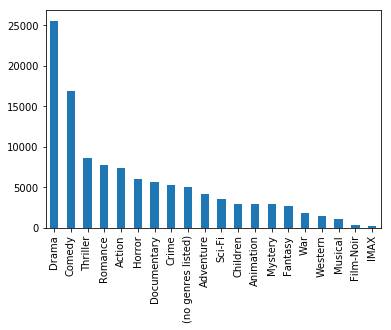

In [213]:
df_movies_catalog = df_movies[df_movies.columns[:-4]]
df_movies_catalog.sum(axis=0).sort_values(ascending=False).plot.bar()

### Plot #2 Number of movies over year

#### INSIGHT:

- Movies production is **increasing year by year**, specifically after 1995, increase significantly. Reasons should be new techniques emerges reduce cost of movie production and some new genres (Fantasy, Thriller, ...) movie show up. 
- Significantly drop down in 2015 caused by incomplete dataset
- **Note**: this plot have ignore the movie which don't have release year info in the dataset

In [214]:
df_movies_basic = df_movies[df_movies.columns[-4:]]
df_movies_byYear = df_movies_basic.groupby(['release_year'])

In [215]:
df_count_byYear = df_movies_byYear.size().reset_index(name='counts')
## remove unknown row

df_count_byYear = df_count_byYear.drop(135)

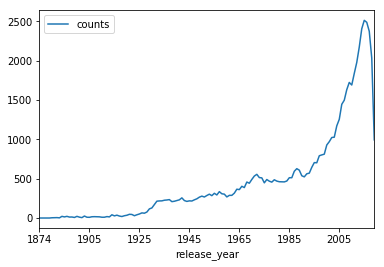

In [216]:
df_count_byYear.sort_values(by='release_year').plot(x='release_year', y='counts')

### Plot #3 Word Cloud for movie title

#### INSIGHT: 

- Word frequency mostly related to base number of movie genres, huge number of drama movies which make words like "love", "family", "girl" become more frequently.

- **Note** : To remove impact from Prepositions and articles word (like the, of, my, his,...) we remove all word whose character length <=3.

In [211]:
text = df_movies_basic.title.values
word_cloud_lst = []

for _title in text:
    word_list = _title.split(' ')
    for _word in word_list:
        if _word is not '' and len(_word)>3:
            word_cloud_lst.append(_word)
            
    

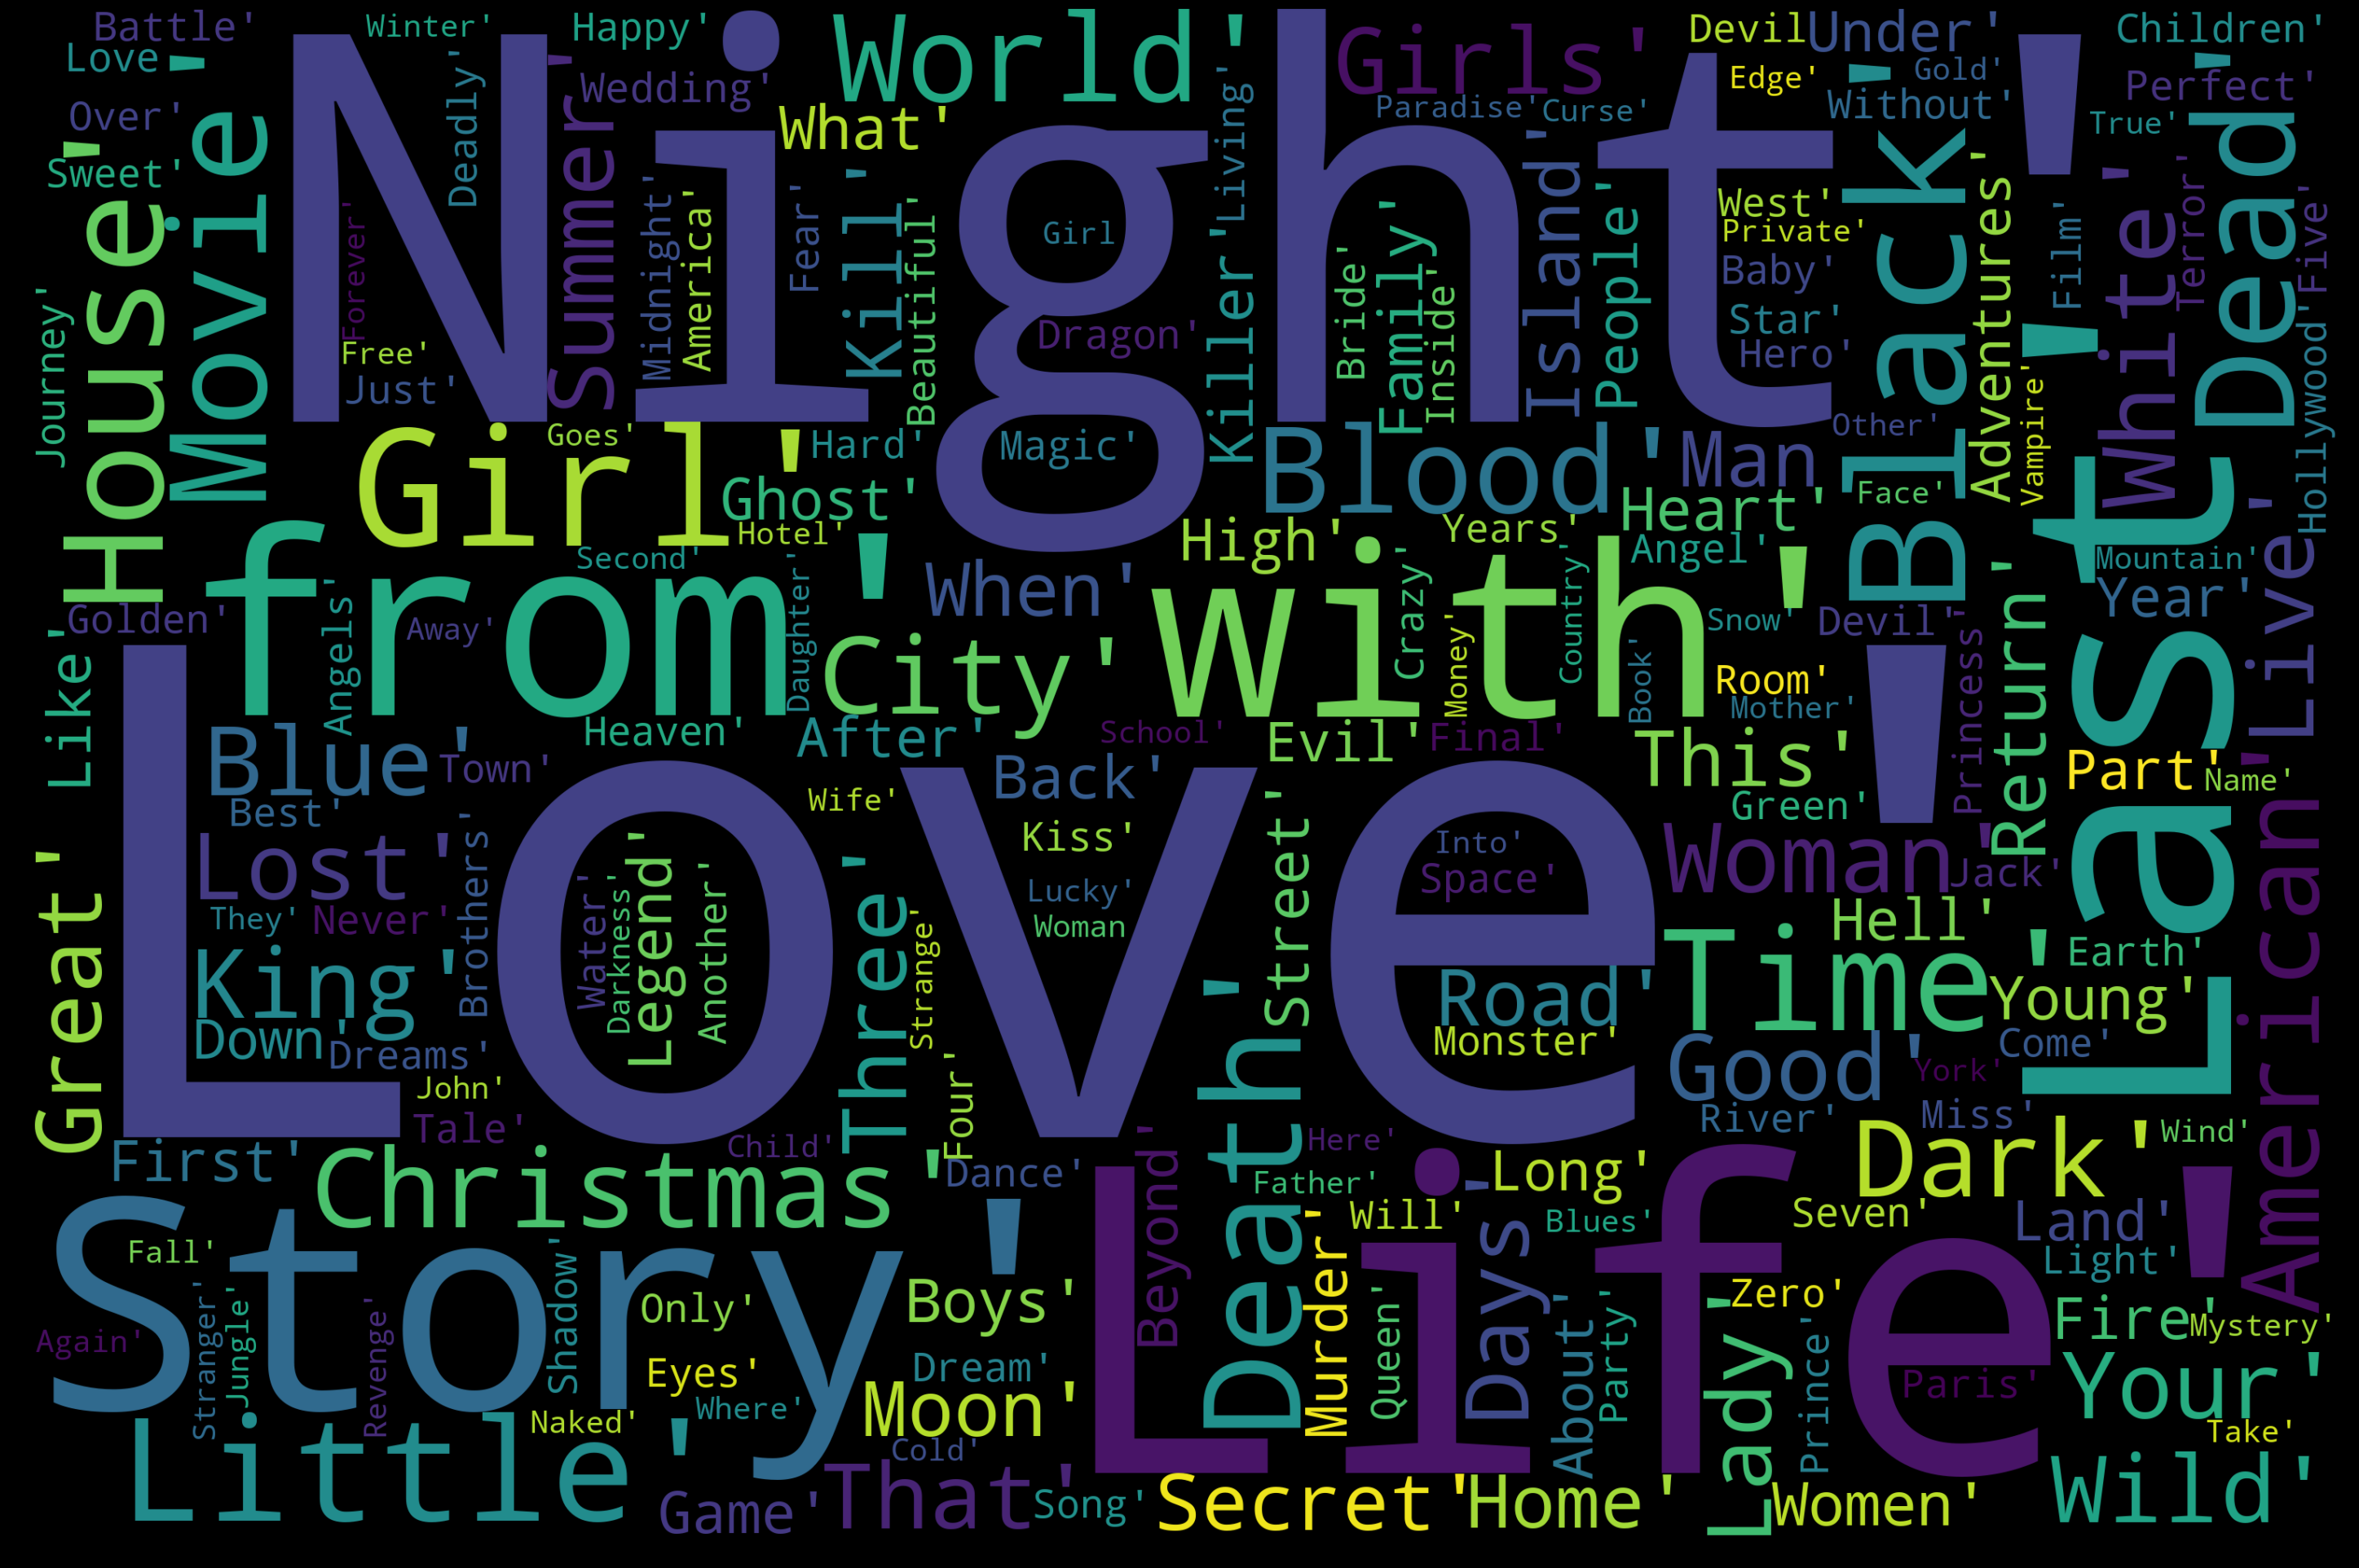

In [212]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(word_cloud_lst))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### 4. Movie rating dataset EDA
- user-movie rating matrix is the most important training data for collaborative filtering recommendation system. This data represents user behavior and preference history for movies.

### Plot#1. Number of movie rating for per year

### INSIGHT: 
- Moive rating increase over year, especially after 2014. Since movie-app like Netflix, become more and more popular, more and more people join for movie rating which enlarge database. 


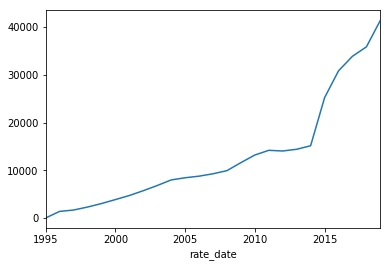

In [218]:
cvt_datatime = pd.to_datetime(df_ratings.timestamp, unit='s')
df_ratings['rate_date'] = cvt_datatime

## only save rating year
df_ratings['rate_date'] = pd.DatetimeIndex(df_ratings.rate_date).year

## find unique movie based on each year

movie_rating_cnt_perYear = df_ratings.groupby('rate_date')['movieId'].nunique()

movie_rating_cnt_perYear.plot()

### Plot#2. Distribution of user rating
### INSIGHT:
- more rating is positive(>=3.5), most rating is 4. average of rating all-time is around 3.5

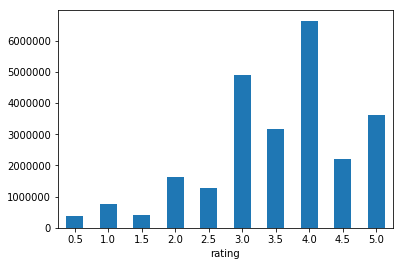

In [219]:
df_ratings.groupby('rating').size().plot.bar(rot=0)

##### box plot for all user rating distribution

max rating score: 5.0
min rating score: 0.5
average rating score: 3.533854451353085


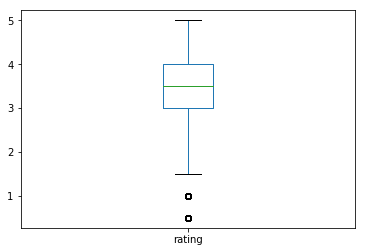

In [220]:
## user rating in whole period
print("max rating score: " + str(df_ratings.rating.max()))
print("min rating score: " + str(df_ratings.rating.min()))
print("average rating score: " + str(df_ratings.rating.mean()))

df_ratings.rating.plot.box()

### Plot #3 User avg-rating distribution

### INSIGHT:
- user avg-rate locate around 3.8, more user rating behavior is positive


C:\Users\13820\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\Users\13820\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  This is separate from the ipykernel package so we can avoid doing imports until


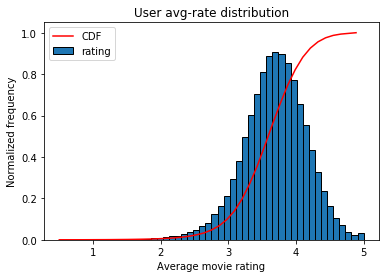

In [236]:
dftmp = df_ratings[['userId','rating']].groupby('userId').mean()
dftmp.plot(kind='hist', bins=50, normed=True, edgecolor='black')
values, base = np.histogram(dftmp, bins=40, normed=True)
cumlative = np.cumsum(values)*np.diff(base).mean()
plt.plot(base[:-1], cumlative, c='red', label='CDF')
plt.legend()
plt.xlabel('Average movie rating')
plt.ylabel('Normalized frequency')
plt.title('User avg-rate distribution')
plt.show()

### Plot #4 variance of rating average over year

### INSIGHT:
- 2005 has less average rating from users
- 2014 has the highest avg-rating from users

In [237]:
### user rating vary by year

ratings_perYear_decade = df_ratings[df_ratings.rate_date>=2000]
ratings_perYear_decade = ratings_perYear_decade[['rating', 'rate_date']].groupby('rate_date')

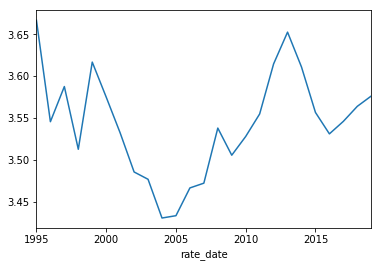

In [238]:
ratings_perYear = df_ratings[['rating', 'rate_date']].groupby('rate_date')
ratings_perYear['rating'].mean().plot()

2000          AxesSubplot(0.1,0.77069;0.173913x0.12931)
2001     AxesSubplot(0.308696,0.77069;0.173913x0.12931)
2002     AxesSubplot(0.517391,0.77069;0.173913x0.12931)
2003     AxesSubplot(0.726087,0.77069;0.173913x0.12931)
2004         AxesSubplot(0.1,0.615517;0.173913x0.12931)
2005    AxesSubplot(0.308696,0.615517;0.173913x0.12931)
2006    AxesSubplot(0.517391,0.615517;0.173913x0.12931)
2007    AxesSubplot(0.726087,0.615517;0.173913x0.12931)
2008         AxesSubplot(0.1,0.460345;0.173913x0.12931)
2009    AxesSubplot(0.308696,0.460345;0.173913x0.12931)
2010    AxesSubplot(0.517391,0.460345;0.173913x0.12931)
2011    AxesSubplot(0.726087,0.460345;0.173913x0.12931)
2012         AxesSubplot(0.1,0.305172;0.173913x0.12931)
2013    AxesSubplot(0.308696,0.305172;0.173913x0.12931)
2014    AxesSubplot(0.517391,0.305172;0.173913x0.12931)
2015    AxesSubplot(0.726087,0.305172;0.173913x0.12931)
2016             AxesSubplot(0.1,0.15;0.173913x0.12931)
2017        AxesSubplot(0.308696,0.15;0.173913x0

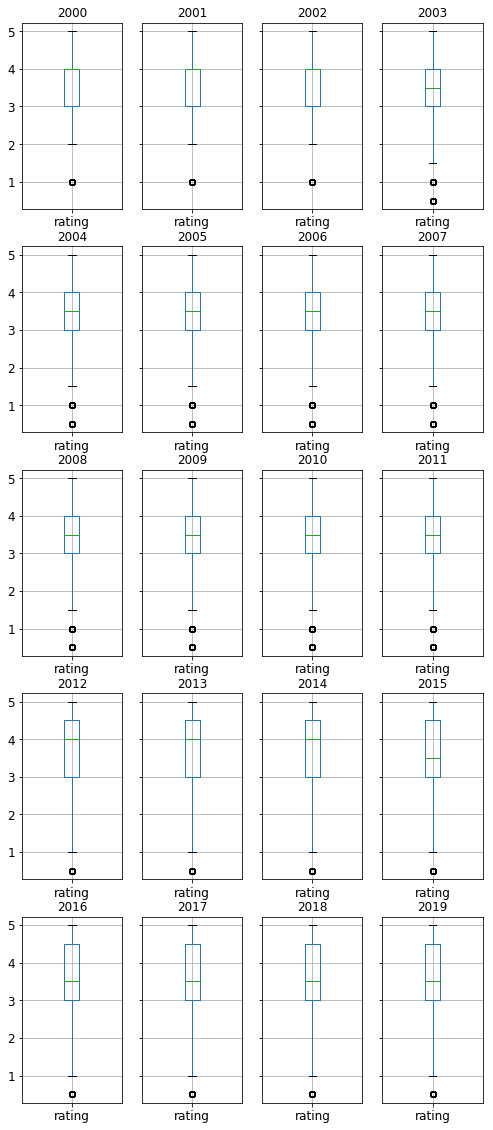

In [239]:
ratings_perYear_decade.boxplot(rot=0, column='rating', fontsize=12, figsize=(8, 20))

### Plot#5 User rating distribution of different tags

### INSIGHT:
- According to avg-rate in each movie genres: top 5: Film-nior, war, documentary, crime, drama
- When we combine avg-rate with number of movie plot: we can find that more movie base number, the less rating-avg score from users.

In [240]:
### index object need to use .union([<list of obj>]) to insert value
df_movies_catalog = df_movies[df_movies.columns[:-4].union(['movieId'])]
## merge df_movies_catalog & df_rating

df_rating_with_catalog = df_ratings.merge(df_movies_catalog, left_on='movieId', right_on='movieId')

In [241]:
df_rating_with_catalog.head()

,userId,movieId,rating,timestamp,rate_date,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,296,5.0,1147880044,2006,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,3,296,5.0,1439474476,2015,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,4,296,4.0,1573938898,2019,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,5,296,4.0,830786155,1996,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,7,296,4.0,835444730,1996,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [242]:
catalog_avg_dict = {}

for _catalog in df_movies.columns[:-4]:
    ratings_mean = df_rating_with_catalog[(df_rating_with_catalog[_catalog]!=0)].rating.mean()
    catalog_avg_dict[_catalog] = ratings_mean

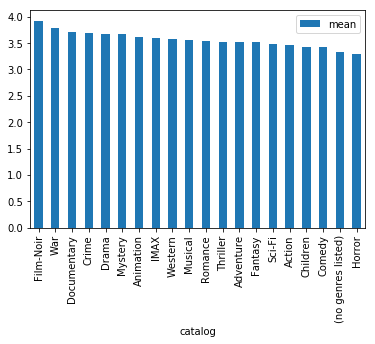

In [243]:
## check avg rating in each catalog
df_catalog_avg = pd.DataFrame({'catalog': list(catalog_avg_dict.keys()), 'mean': list(catalog_avg_dict.values())})

df_catalog_avg.sort_values(by='mean', ascending=False).plot(x='catalog', y='mean', kind='bar', rot=90)

##### Count base number of each topic movies

In [135]:
count_base_dict = {}

for _catalog in df_movies.columns[:-4]:
    base_cnt = df_rating_with_catalog[(df_rating_with_catalog[_catalog]!=0)].groupby('userId').ngroups
    count_base_dict[_catalog] = base_cnt
    
df_count_base = pd.DataFrame({'catalog': list(count_base_dict.keys()),'base_cnt': list(count_base_dict.values())})

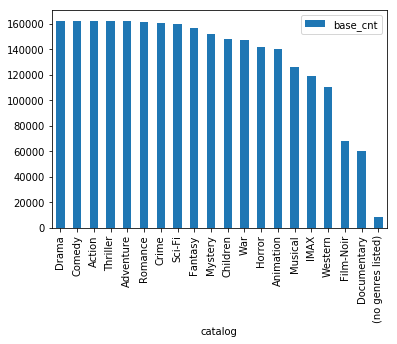

In [136]:
df_count_base.sort_values(by='base_cnt', ascending=False).plot(x='catalog', y='base_cnt', kind='bar', rot=90)